In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import stencil, njit


## Matrix-free iterative solution of Poisson's equation with the conjugate gradient method
### Reformulate linear solve as minimization problem
For large grids, it becomes inefficient to even store the sparse matrix, as it just stores the same information as the stencil representation. Instead, we can use iterative solvers that do not require the matrix to be stored explicitly. The best *iterative solver* for linear systems of equations $$A\vec{\phi}=\vec{\rho}$$ with a symmetric positive definite matrix $A$ is the *conjugate gradient method*. The idea is to replace the exact linear solution with a minimization problem. It does so by first defining the quadratic function 
$$
  f(\vec{\phi}) = \tfrac{1}{2} \vec{\phi}^\top A \vec{\phi} - \vec{\rho}^\top \vec{\phi} \, .
$$
whose minimum solves the linear system of equations.  

### Iterative minimization with conjugate gradients
The conjugate gradient method works as follows (Hestenes et al. 1952). Starting with an initial guess $\vec{\phi}_0$, in each step $a=1,2,\ldots$, one updates the approximate solution
$$
  \vec{\phi}_{a+1} = \vec{\phi}_a + \alpha_a \vec{p}_a \, ,
$$
where $\alpha_a$ is a step size and $\vec{p}_a$ is the search direction. Steps are continued, unitl the *residual* $\vec{r}_a=\vec{\rho}-A\phi_a$ is smaller than a given tolerance, i.e. $\|\vec{r}_a\|<\epsilon$. The search direction is chosen $A$-conjugate to all previous search directions, i.e. 
$$
  \vec{p}_a^\top A \vec{p}_b = 0 \quad \forall b<a \, .
$$
The choice of $A$-conjugate search directions leads to independent updates and is crucial for the convergence of the method.

The step size $\alpha_a$ is chosen to minimize the quadratic function $f(\vec{\phi}_a+\alpha_a \vec{p}_a)$, which leads to the equation
$$
  \alpha_a = \frac{\vec{r}_a^\top \vec{r}_a}{\vec{p}_a^\top A \vec{p}_a} \, .
$$
The search direction is then updated using the residual
$$
  \vec{p}_{a+1} = \vec{r}_{a+1} + \beta_a \vec{p}_a \, ,
$$
where $\beta_a$ is chosen to minimize the quadratic function $f(\vec{\phi}_a+\alpha_a \vec{p}_a+\beta_a \vec{p}_{a+1})$. This leads to the equation
$$
  \beta_a = \frac{\vec{r}_{a+1}^\top \vec{r}_{a+1}}{\vec{r}_a^\top \vec{r}_a} \, .
$$
In the equations above, the matrix $A$ is never needed explicitly, but only appears in the matrix-vector product $A\vec{x}$ with some $\vec{x}$. This matrix-vector product can be evaluated using the stencil representation.

### Expected convergence rate / algorithm complexity
The number of iterations needed depends naturally on the desired accuracy, and on the structure of the matrix $A$. One can show that to reach a tolerance $\epsilon$ typically
$$
  k\sim\mathcal{O}\left(\sqrt{\kappa(A)}\log \frac{1}{\epsilon}\right)
$$
iterations are needed, where $\kappa(A)$ is the *condition number* of the matrix $A$. For a symmetric positive definite matrix, such as in our case, $\kappa(A)= \frac{\lambda_\text{max}}{\lambda_\text{min}}$ is the ratio of the largest to the smallest eigenvalue (by absolute value) of $A$. For the second order Laplacian, this ratio turns out to be $\kappa(A)\sim \mathcal{O}(N^2)$ so that $k\sim \mathcal{O}(N\log \frac{1}{\epsilon})$ and the total complexity becomes $\mathcal{O}(N^{d+1})$ dimensions. 

In [12]:
# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]

@njit
def apply_A(u, h):
    """ Matrix-vector product with the Laplacian operator """
    return laplacian_2d(u) / h**2

In [17]:
def cg_2d_stencil(rho, h, tol=1e-8, max_iter=1000, verbose=False):
    """
    Solve the 2D Poisson equation using the matrix-free Conjugate Gradient method with a stencil-based Laplacian. This version only implements zero Dirichlet boundary conditions and a 5-point 2nd order stencil for the Laplacian.

    Parameters:
      rho (numpy.ndarray): source term.
      tol (float, optional): The tolerance for the convergence criterion. Default is 1e-8.
      max_iter (int, optional): The maximum number of iterations. Default is 1000.

    Returns:
      numpy.ndarray: The solution to the Poisson equation, excluding ghost boundaries.
    """
    N = rho.shape[0]
    u = np.zeros((N + 2, N + 2)) # Initialize solution with ghost boundaries

    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    r = rhs - apply_A(u, h)

    p = r.copy()
    for it in range(max_iter):
        Ap = apply_A(p, h)
        r_inner = r[1:-1, 1:-1]
        Ap_inner = Ap[1:-1, 1:-1]

        alpha = np.sum(r_inner * r_inner) / np.sum(p[1:-1, 1:-1] * Ap_inner)
        u[1:-1, 1:-1] += alpha * p[1:-1, 1:-1]
        r_new = r - alpha * Ap

        err = np.linalg.norm(r_new[1:-1, 1:-1])
        
        if verbose:
            print(f"Iteration {it}: error = {err : .4g}")

        if err < tol:
            break

        beta = np.sum(r_new[1:-1, 1:-1]**2) / np.sum(r_inner**2)
        p = r_new + beta * p
        r = r_new

    return u[1:-1, 1:-1]  # strip ghost boundaries


### Example usage

In [22]:
# Example usage: single point source in the center
N = 64
h = 1.0 / (N + 1)
rho = np.zeros((N,N))
rho[N//2,N//2] = 1.0

phicg = cg_2d_stencil( rho, h, tol=1e-4, verbose=True) 

Iteration 0: error =  0.5
Iteration 1: error =  0.3727
Iteration 2: error =  0.3113
Iteration 3: error =  0.2724
Iteration 4: error =  0.2454
Iteration 5: error =  0.225
Iteration 6: error =  0.209
Iteration 7: error =  0.196
Iteration 8: error =  0.1851
Iteration 9: error =  0.1759
Iteration 10: error =  0.1679
Iteration 11: error =  0.161
Iteration 12: error =  0.1548
Iteration 13: error =  0.1493
Iteration 14: error =  0.1443
Iteration 15: error =  0.1398
Iteration 16: error =  0.1357
Iteration 17: error =  0.1319
Iteration 18: error =  0.1285
Iteration 19: error =  0.1253
Iteration 20: error =  0.1223
Iteration 21: error =  0.1195
Iteration 22: error =  0.1169
Iteration 23: error =  0.1145
Iteration 24: error =  0.1122
Iteration 25: error =  0.11
Iteration 26: error =  0.108
Iteration 27: error =  0.1061
Iteration 28: error =  0.1043
Iteration 29: error =  0.1025
Iteration 30: error =  0.1009
Iteration 31: error =  0.09929
Iteration 32: error =  0.09779
Iteration 33: error =  0.096

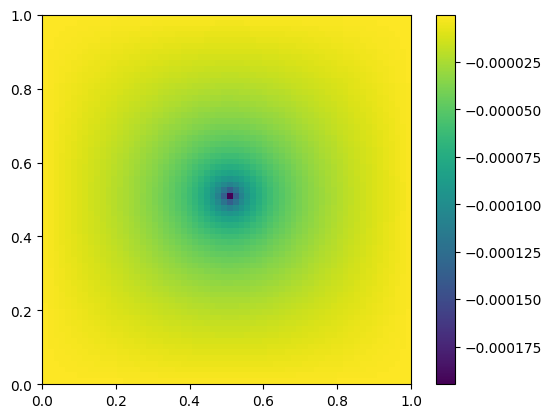

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(phicg, extent=(0, 1, 0, 1), origin='lower')
plt.colorbar(im)